In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import utils 
import itertools

WACC = utils.WACC
N = utils.N

In [2]:
h2_costs = pd.read_excel('./h2_tech.xlsx', sheet_name='Summary')
h2_costs['H2 eff (kgh2/MWhe)'] = h2_costs.apply(lambda d: d['H2Cap (kgh2/h)']/d['H2Cap (MWe)'], axis=1)
h2_eff = h2_costs[['Technology', 'ANR', 'H2 eff (kgh2/MWhe)']]
h2_costs =h2_costs[['Technology', 'CAPEX ($/MWe)', 'FOM ($/MWe-year)', 'VOM ($/MWhe)', 'Life (y)']]

h2_costs.drop_duplicates(ignore_index=True, inplace=True)
h2_costs['CRF'] = h2_costs.apply(lambda d: WACC/ (1-np.power(1+WACC, -d['Life (y)'])), axis =1)
h2_tech_list = list(h2_costs['Technology'])
h2_costs.set_index('Technology', inplace=True)
h2_eff.set_index(['Technology','ANR'], inplace=True)
h2_costs


,CAPEX ($/MWe),FOM ($/MWe-year),VOM ($/MWhe),Life (y),CRF
Technology,,,,,
HTSE,646487,30313.2,2.76,20,0.099589
PEM,1500000,12800.0,1.30,20,0.099589
Alkaline,743865,60020.0,0.00,20,0.099589


In [3]:
anr_params = pd.read_excel('./ANRs.xlsx', sheet_name='FOAK')
reactors_list = list(anr_params['Reactor'])
anr_params.set_index('Reactor', inplace=True)
anr_params['CRF'] = anr_params.apply(lambda d: WACC/ (1-np.power(1+WACC, -d['Life (y)'])), axis =1)
anr_params

,Type,Power in MWe,Power in MWt,MSL in MWe,Thermal Efficiency,Thermal transfer efficiency,MDT in hours,Ramp Rate (fraction of capacity/hr),Ramp Rate (MW/hr),Outlet Temp (C),CAPEX $/MWe,FOPEX $/MWe-y,Max Modules,VOM in $/MWh-e,Startupfixedcost in $,Life (y),CRF
Reactor,,,,,,,,,,,,,,,,,
iPWR,PWR,77.0,250,15.4,0.31,1.000,20,0.4,24.0,302,5535000,115000,12,9.75,38500,30,0.086325
HTGR,HTGR,164.0,350,32.8,0.47,0.897,20,6.0,984.0,950,7500000,164000,4,13.00,82000,30,0.086325
PBR-HTGR,HTGR,80.0,200,32.0,0.40,0.751,20,2.4,48.0,750,4569000,100000,12,13.00,40000,30,0.086325
iMSR,MSR,141.0,300,28.2,0.47,0.936,20,0.6,84.6,700,4091000,85000,12,11.50,70500,30,0.086325
Micro,HTGR,6.7,20,2.7,0.33,0.897,20,6.0,24.0,630,10902000,264000,12,0.00,3350,30,0.086325


In [4]:
lcoh_df = pd.DataFrame(columns=['Reactor', 'H2 tech', 'LR (%)', 'LCOH ($/kg)'])
lcoh_df.set_index(['Reactor','H2 tech', 'LR (%)'], inplace=True)
learning_rates = [0, 0.03, 0.07,0.1]
combinations = list(itertools.product(reactors_list, h2_tech_list, learning_rates))

def update_capex_anr(capex_foak, lr):
  return capex_foak*np.power(N, np.log2(1-lr))

for tup in combinations:
  r = tup[0]
  h = tup[1]
  lr = tup[2]
  anr_capex = update_capex_anr(anr_params.loc[r, 'CAPEX $/MWe'], lr)
  r_num = anr_params.loc[r, 'Power in MWe']*(anr_capex*anr_params.loc[r, 'CRF'] + anr_params.loc[r, 'FOPEX $/MWe-y'] +\
                                             anr_params.loc[r,'VOM in $/MWh-e']*365*24)
  h_num = anr_params.loc[r, 'Power in MWe']*(h2_costs.loc[h, 'CAPEX ($/MWe)']*h2_costs.loc[h,'CRF'] + h2_costs.loc[h,'FOM ($/MWe-year)'] +\
                                             h2_costs.loc[h, 'VOM ($/MWhe)']*365*24)
  den = h2_eff.loc[h, r][0]*365*24*anr_params.loc[r,'Power in MWe']
  lcoh = (r_num+h_num)/den 
  lcoh_df.loc[r, h, lr] = lcoh 

lcoh_df



C:\Users\mgarrou\AppData\Local\Temp\ipykernel_10224\1810158657.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  den = h2_eff.loc[h, r][0]*365*24*anr_params.loc[r,'Power in MWe']
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_10224\1810158657.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  den = h2_eff.loc[h, r][0]*365*24*anr_params.loc[r,'Power in MWe']
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_10224\1810158657.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

LCOH ($/kg)
Reactor  H2 tech  LR (%)             
iPWR     HTSE     0.00       3.003628
                  0.03       2.532246
                  0.07       2.076706
                  0.10       1.833193
         PEM      0.00       9.820897
                  0.03       8.378600
                  0.07       6.984779
                  0.10       6.239697
         Alkaline 0.00       5.007464
                  0.03       4.236335
                  0.07       3.491124
                  0.10       3.092763
HTGR     HTSE     0.00       2.720627
                  0.03       2.278987
                  0.07       1.852190
                  0.10       1.624041
         PEM      0.00      12.669874
                  0.03      10.715542
                  0.07       8.826896
                  0.10       7.817300
         Alkaline 0.00       6.530679
                  0.03       5.485789
                  0.07       4.476018
                  0.10       3.936234
PBR-HTGR HTSE     0.00       1.713343
                  0.03       1.470040
                  0.07       1.234915
                  0.10       1.109227
         PEM      0.00       9.014738
                  0.03       7.824159
                  0.07       6.673596
                  0.10       6.058550
         Alkaline 0.00       4.576448
                  0.03       3.939901
                  0.07       3.324748
                  0.10       2.995912
iMSR     HTSE     0.00       1.607845
                  0.03       1.381839
                  0.07       1.163430
                  0.10       1.046677
         PEM      0.00       8.214537
                  0.03       7.148514
                  0.07       6.118321
                  0.10       5.567620
         Alkaline 0.00       4.148618
                  0.03       3.578665
                  0.07       3.027869
                  0.10       2.733434
Micro    HTSE     0.00       2.596478
                  0.03       2.113280
                  0.07       1.646323
                  0.10       1.396706
         PEM      0.00      15.895867
                  0.03      13.055050
                  0.07      10.309715
                  0.10       8.842166
         Alkaline 0.00       8.255468
                  0.03       6.736615
                  0.07       5.268812
                  0.10       4.484182

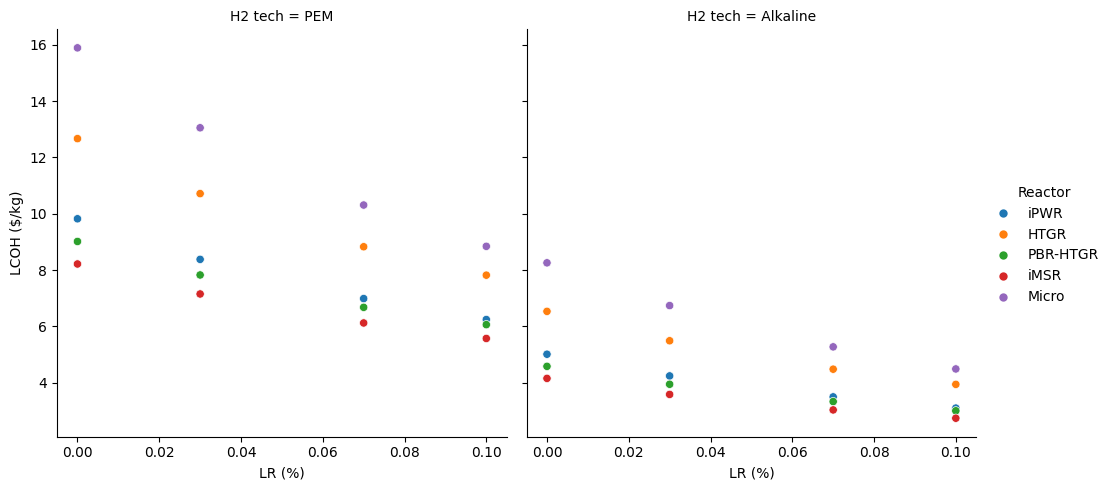

In [5]:
lcoh_df = lcoh_df.reset_index()
import seaborn as sns 


#sns.scatterplot(data=lcoh_df, x='LR (%)', y='LCOH ($/kg)', hue='Reactor', style='H2 tech')
sns.relplot(
    data=lcoh_df[lcoh_df['H2 tech'] !='HTSE'], x='LR (%)', y='LCOH ($/kg)',
    col="H2 tech", hue="Reactor",
    kind="scatter"
)
plt.savefig('./results/lcoh_pem_ael.png')

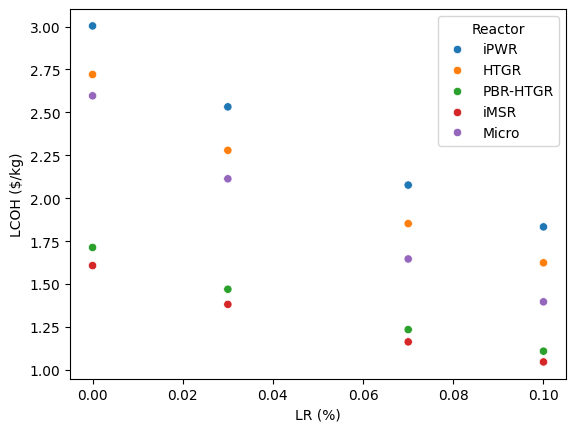

In [6]:
sns.scatterplot(data=lcoh_df[lcoh_df['H2 tech']=='HTSE'], x='LR (%)', y='LCOH ($/kg)', hue='Reactor')
plt.savefig('./results/lcoh_htse.png')

In [7]:
lcoh_foak = lcoh_df[lcoh_df['LR (%)'] ==0]
lcoh_foak.to_excel('./results/lcoh_foak.xlsx')